# RAI/USD vs ETH/USD, WIP

Compare RAI/USD and ETH/USD

In [1]:
import os
import time
from decimal import Decimal
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from web3 import Web3, HTTPProvider

from abis import LINK_ETH, LINK_ETH_ABI, LINK_ETH_FIRST_BLOCK
from abis import LINK_RAI, LINK_RAI_ABI, LINK_RAI_FIRST_BLOCK
from abis import ORACLE_RELAYER, ORACLE_RELAYER_ABI, ORACLE_RELAYER_FIRST_BLOCK

from mp import fetch, fetch_link_mp, fetch_rp

size = 15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,12),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}

plt.rcParams.update(params)

In [2]:
# Need an archive node
ETH_RPC_URL=os.environ['ETH_RPC_URL']
web3 = Web3(HTTPProvider(endpoint_uri=ETH_RPC_URL, request_kwargs={"timeout": 10}))

In [3]:
first_block = max(LINK_ETH_FIRST_BLOCK, ORACLE_RELAYER_FIRST_BLOCK)
interval = 6600 * 7
interval = 275 # 1 hour
num_blocks = None

latest_block = web3.eth.getBlock("latest")['number']

if not num_blocks:
    last_block = latest_block - 12
else:
    last_block = min(latest_block - 12, first_block + num_blocks)

print(f"first block {first_block}, last_block {last_block}")
blocks = list(range(first_block, last_block + 1, interval))

first block 12000000, last_block 14826848


In [4]:
start = time.time()
rp_results = fetch(fetch_rp, 8, ORACLE_RELAYER, ORACLE_RELAYER_ABI, ETH_RPC_URL, blocks=blocks)
print(f"took {time.time() - start}")

took 167.93343114852905


In [5]:
"""
start = time.time()
rai_results = fetch(fetch_link_mp, 8, LINK_RAI, LINK_RAI_ABI, ETH_RPC_URL, blocks=blocks)
print(f"took {time.time() - start}")
"""

'\nstart = time.time()\nrai_results = fetch(fetch_link_mp, 8, LINK_RAI, LINK_RAI_ABI, ETH_RPC_URL, blocks=blocks)\nprint(f"took {time.time() - start}")\n'

In [6]:
len(rp_results)

10280

In [7]:
start = time.time()
eth_results = fetch(fetch_link_mp, 8, LINK_ETH, LINK_ETH_ABI, ETH_RPC_URL, blocks=blocks)
print(f"took {time.time() - start}")

took 189.74723410606384


In [55]:
rai_df = pd.DataFrame(rp_results, columns = ['block', 'price'])
eth_df = pd.DataFrame(eth_results, columns = ['block', 'price', 'ts', 'started_at'])

In [56]:
rai_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10280 entries, 0 to 10279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   block   10280 non-null  int64 
 1   price   10280 non-null  object
dtypes: int64(1), object(1)
memory usage: 160.8+ KB


In [57]:
rai_df.to_csv('redemption_price_1h_blocks.csv')

In [58]:
eth_df.to_csv('eth_usd_1h_blocks.csv')

Read existing csvs

In [59]:
#rai_df = pd.read_csv('redemption_price_7d_blocks.csv')

In [60]:
#eth_df = pd.read_csv('eth_usd_7d_blocks.csv')

In [63]:
rai_df.head(4)

,block,price,rai_ret
0,12000000,3022808657486628987514678542,NaN
1,12000275,3022574225951693337830830920,-0.000078
2,12000550,3022342258257112740097556937,-0.000077
3,12000825,3022110372667931165365910820,-0.000077


In [61]:
rai_df['rai_ret'] = rai_df['price'].pct_change()
eth_df['eth_ret'] = eth_df['price'].pct_change()

In [41]:
df = rai_df.merge(eth_df, on='block')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10280 entries, 0 to 10279
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   block       10280 non-null  int64  
 1   price_x     10280 non-null  object 
 2   rai_ret     10279 non-null  object 
 3   price_y     10280 non-null  int64  
 4   ts          10280 non-null  int64  
 5   started_at  10280 non-null  int64  
 6   eth_ret     10279 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 642.5+ KB


In [43]:
df_final = df[['block', 'rai_ret', 'eth_ret']]

In [44]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10280 entries, 0 to 10279
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   block    10280 non-null  int64  
 1   rai_ret  10279 non-null  object 
 2   eth_ret  10279 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 321.2+ KB


In [45]:
df_final_index = df_final.set_index('block')

<AxesSubplot:title={'center':'Rolling 10-period correlation between 7d ETH/USD and 7d redemption price returns'}, xlabel='block'>

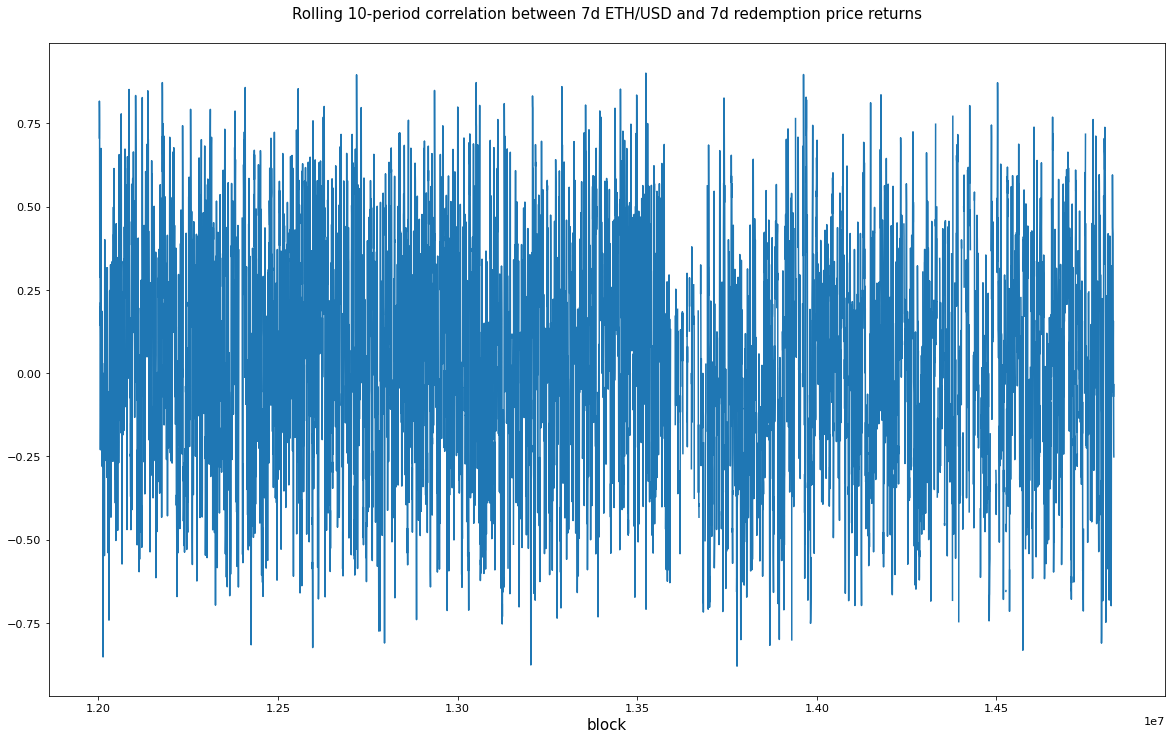

In [46]:
df_final_index['rai_ret'].rolling(10).corr(df_final_index['eth_ret']).plot(title='Rolling 10-period correlation between 7d ETH/USD and 7d redemption price returns')



In [47]:
rai_df['price_norm'] = (rai_df['price'] - min(rai_df['price'])) / (max(rai_df['price']) - min(rai_df['price']))
eth_df['price_norm'] = (eth_df['price'] - min(eth_df['price'])) / (max(eth_df['price']) - min(eth_df['price']))

<AxesSubplot:xlabel='block'>

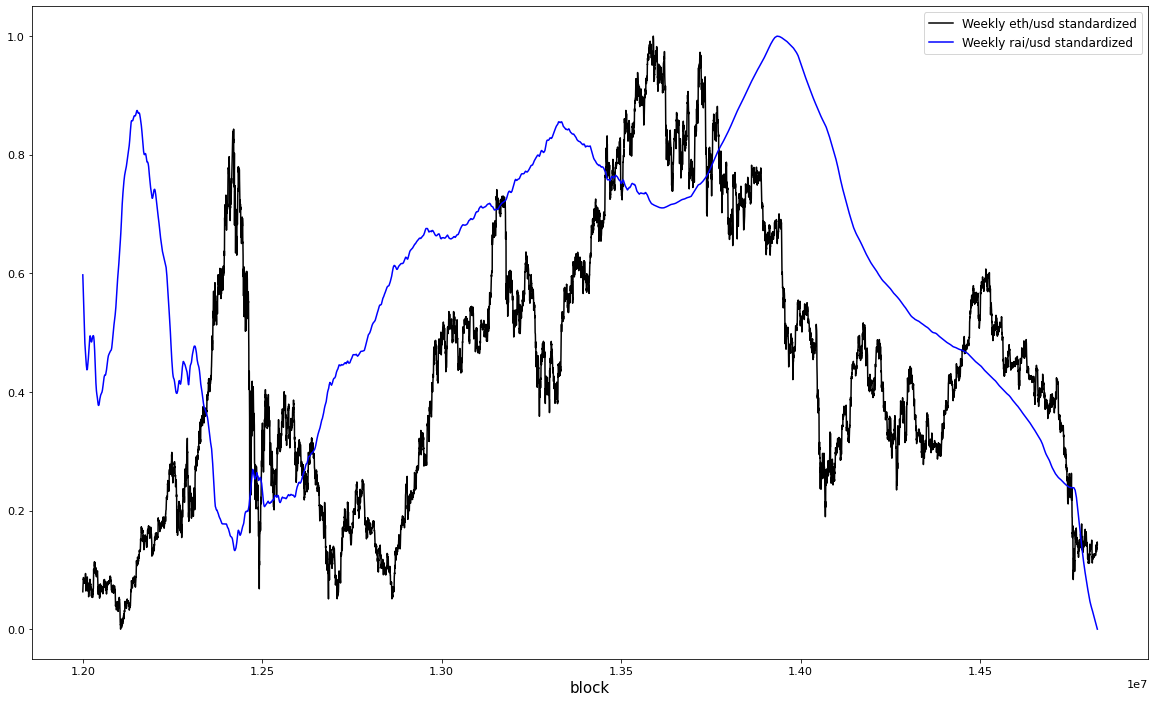

In [48]:
fig, ax = plt.subplots(1,1)
eth_df.plot(y='price_norm', x='block', ax=ax, label='Weekly eth/usd standardized', color='black')
rai_df.plot(y='price_norm', x='block', ax=ax, label='Weekly rai/usd standardized', color='blue')

<AxesSubplot:xlabel='block'>

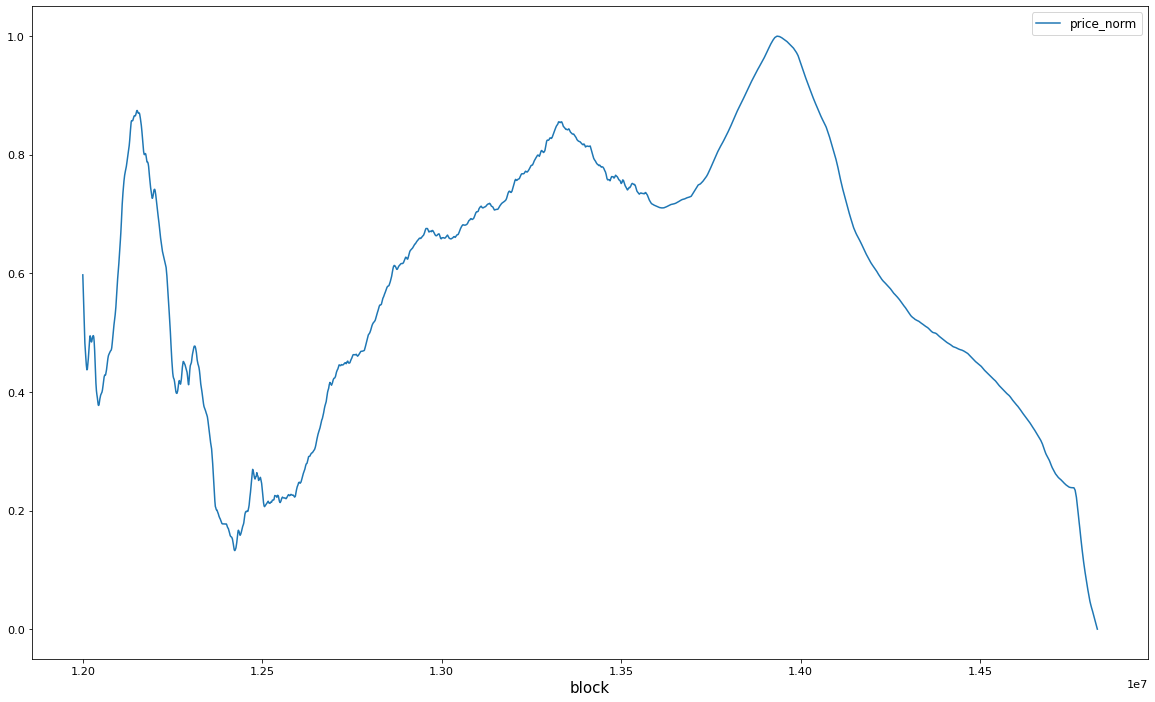

In [49]:
rai_df.plot(y='price_norm', x='block')

In [50]:
'''
# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas

lagged_correlation = pd.DataFrame.from_dict(
    {x: [df[target].corr(df[x].shift(-t)) for t in range(max_lag)] for x in df.columns})
'''

'\n# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas\n\nlagged_correlation = pd.DataFrame.from_dict(\n    {x: [df[target].corr(df[x].shift(-t)) for t in range(max_lag)] for x in df.columns})\n'

In [51]:
df_final_index['rai_ret'].astype(float).corr(df_final_index['eth_ret'].shift(1))

0.009832878213790227

In [52]:
'''
# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas

lagged_correlation = pd.DataFrame.from_dict(
    {x: [df[target].corr(df[x].shift(-t)) for t in range(max_lag)] for x in df.columns})
'''

'\n# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas\n\nlagged_correlation = pd.DataFrame.from_dict(\n    {x: [df[target].corr(df[x].shift(-t)) for t in range(max_lag)] for x in df.columns})\n'

In [64]:
max_lag = 168
for x in range(max_lag):
    corr = df_final_index['rai_ret'].iloc[-24*30:].astype(float).corr(df_final_index['eth_ret'].iloc[-24*30:].shift(x))
    print(x, corr)


0 -0.046191493538783726
1 -0.05014114636801597
2 -0.05564152084615059
3 -0.06047060557967625
4 -0.06642234119314856
5 -0.0658824104933003
6 -0.07125536208032476
7 -0.06150564599975051
8 -0.06149589380798468
9 -0.05387496157759212
10 -0.04813773647739101
11 -0.0519934433460787
12 -0.049785525020607714
13 -0.06385463959653184
14 -0.06620160312515166
15 -0.06972308691083022
16 -0.08201329264034368
17 -0.07817891516818369
18 -0.07197789487792464
19 -0.06818159437432743
20 -0.061208714474555746
21 -0.05365993097222626
22 -0.04171972516884788
23 -0.038062642878792755
24 -0.04799480865533026
25 -0.049084826792457285
26 -0.047580345681840164
27 -0.0547248957139309
28 -0.055575120176690716
29 -0.05175753532721263
30 -0.04964112633817706
31 -0.051383555279953676
32 -0.04898746722834902
33 -0.025741908205238764
34 -0.016077994085396917
35 -0.007994076076497337
36 -0.011139422762261932
37 -0.014919868024849996
38 -0.014854432248492734
39 -0.027334934498147258
40 -0.02958051082504182
41 -0.01247366